In [0]:
# 初回のみ下記3行実行し、コメントアウトしランタイムを再起動(colab用
#!pip3 uninstall numpy -y
#!pip3 install numpy==1.16.2


from __future__ import print_function

import numpy as np
import pandas as pd
import keras
import time
import matplotlib.pyplot as plt
import keras.backend as K
from keras.callbacks import CSVLogger
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, GlobalMaxPool1D
from keras.layers import RNN, SimpleRNN, GRU, LSTM, ConvLSTM2D
from keras.layers import SimpleRNNCell, GRUCell, LSTMCell, StackedRNNCells
from keras.layers import CuDNNGRU, CuDNNLSTM
from keras.datasets import imdb

# 発展的なRNNの手法を理解する
## 【問題1】各種手法の実行
## 【問題2】比較結果の説明
- IMDB映画レビュー感情分類を用いる  
https://keras.io/ja/datasets/#imdb

In [3]:
max_features = 6000
# cut texts after this number of words (among top max_features most common words)
maxlen = 1000
embedding_dim = 128


print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17465344/17464789 [==============================] - 1s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 1000)
x_test shape: (25000, 1000)


### RNN using a different kind of cells

In [0]:
def fit_rnn_cell(x_train, y_train, x_test, y_test, m_name, model):
    epochs = 5
    batch_size = 1024
    max_features = 6000
    maxlen = 1000
    embedding_dim = 128
    
    print('Build {} model...'.format(m_name))
    
    seq_obj = Sequential()
    seq_obj.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    seq_obj.add(model)
    seq_obj.add(Dense(20, activation="relu"))
    seq_obj.add(Dropout(0.05))
    seq_obj.add(Dense(1, activation="sigmoid"))
    seq_obj.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print('Train...')
    
    csv_logger = CSVLogger('{}_training.log'.format(m_name))
    
    seq_obj.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              callbacks=[csv_logger])
    score, acc = seq_obj.evaluate(x_test, y_test,
                                batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)
    
    K.clear_session()

In [15]:
n_units = 128
models = {'SimpleRNNCell' : RNN(SimpleRNNCell(n_units)),
                    'GRUCell' : RNN(GRUCell(n_units)),
                    'LSTMCell' : RNN(LSTMCell(n_units)),
                    'SimpleRNN': SimpleRNN(n_units),
                    'GRU': GRU(n_units),
                    'LSTM': LSTM(n_units),
                    'CuDNNGRU' : CuDNNGRU(n_units),
                    'CuDNNLSTM' : CuDNNLSTM(n_units)}

elapsed_time_list = {}

for m_name in models:
    t1 = time.time()
    
    fit_rnn_cell(x_train, y_train, x_test, y_test, m_name, models[m_name])
    
    t2 = time.time()
    elapsed_time_list[m_name] = t2-t1

Build SimpleRNNCell model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 37s 1ms/step - loss: 0.6919 - acc: 0.5172 - val_loss: 0.6867 - val_acc: 0.5728
Epoch 2/5
25000/25000 [==============================] - 36s 1ms/step - loss: 0.6655 - acc: 0.6142 - val_loss: 0.6199 - val_acc: 0.6841
Epoch 3/5
25000/25000 [==============================] - 36s 1ms/step - loss: 0.5696 - acc: 0.7044 - val_loss: 0.4655 - val_acc: 0.7943
Epoch 4/5
25000/25000 [==============================] - 36s 1ms/step - loss: 0.4139 - acc: 0.8118 - val_loss: 0.4158 - val_acc: 0.8234
Epoch 5/5
25000/25000 [==============================] - 14s 568us/step
Test score: 0.3715480473804474
Test accuracy: 0.8517599996757508
Build GRUCell model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 73s 3ms/step - loss: 0.6733 - acc: 0.6101 - val_loss: 0.5367 - val_acc: 0.7522
Epoch 2/5
250

- SimpleRNN(Cell)  
出力が入力にフィードバックされる全結合RNN
- GRU(Cell)  
ゲートのあるリカレントユニット
- LSTM(Cell)  
長短期記憶ユニット
- CuDNNGRU・CuDNNLSTM  
nvidiaの[cuDNN](https://developer.nvidia.com/cudnn)を用いて高速化したGRU・LSTM  

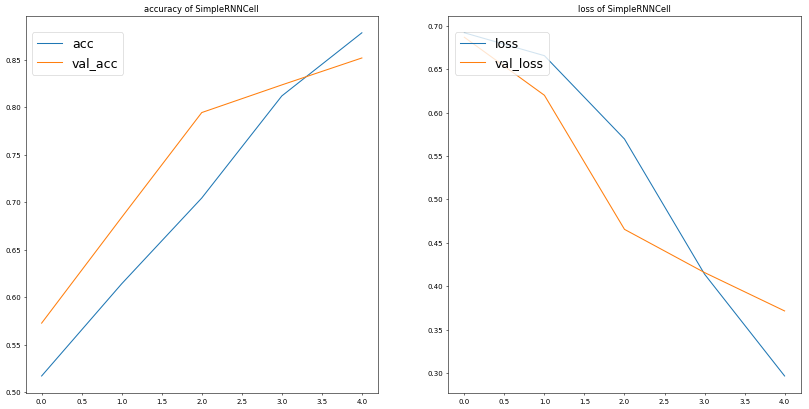

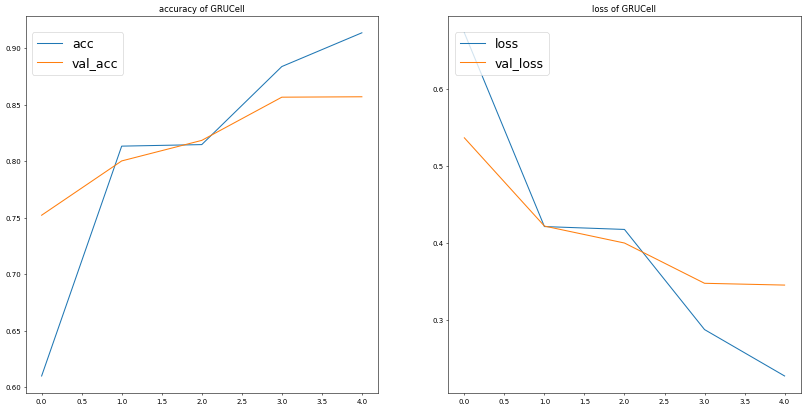

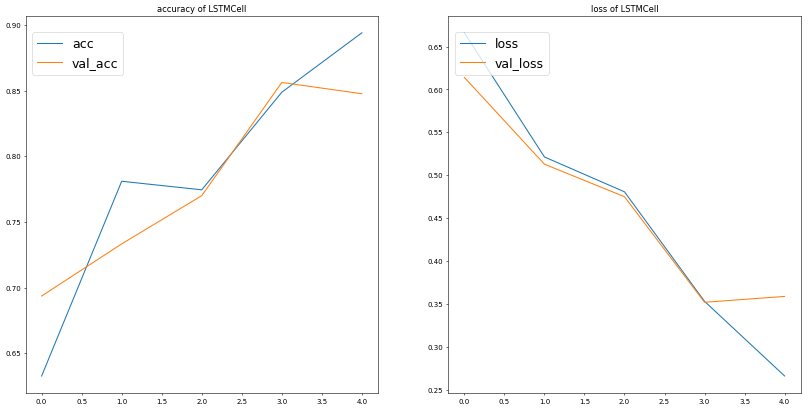

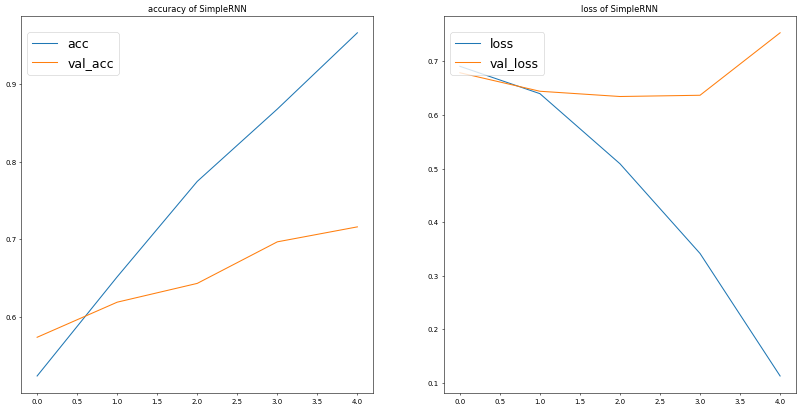

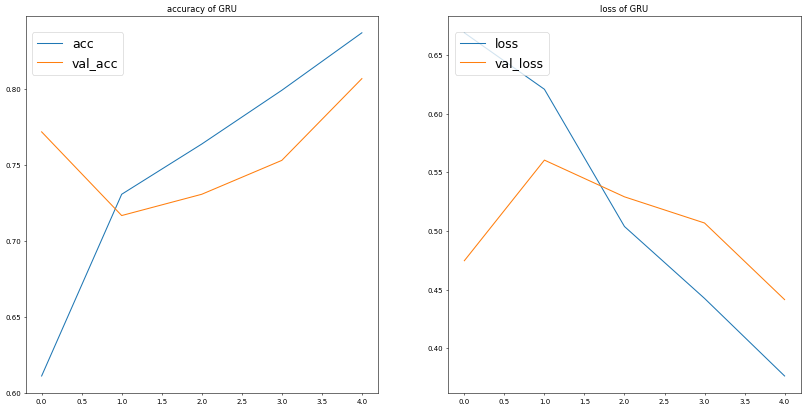

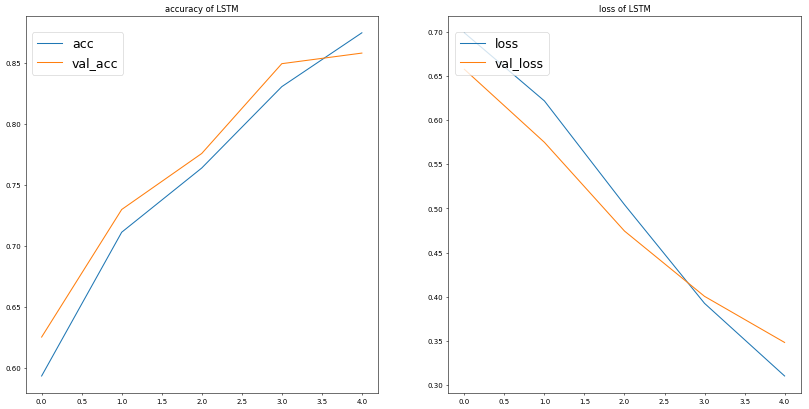

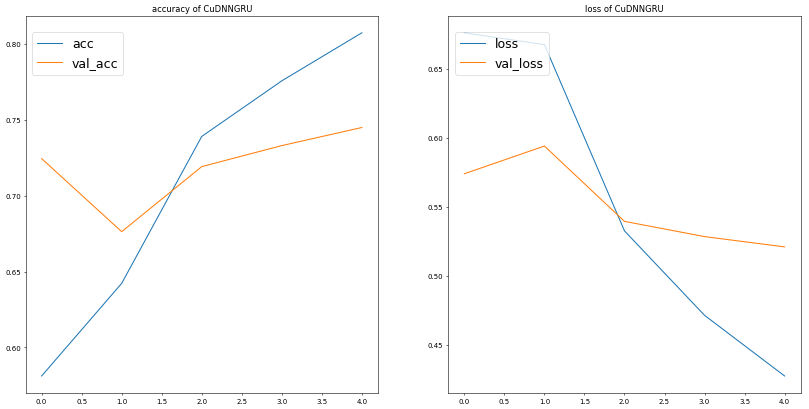

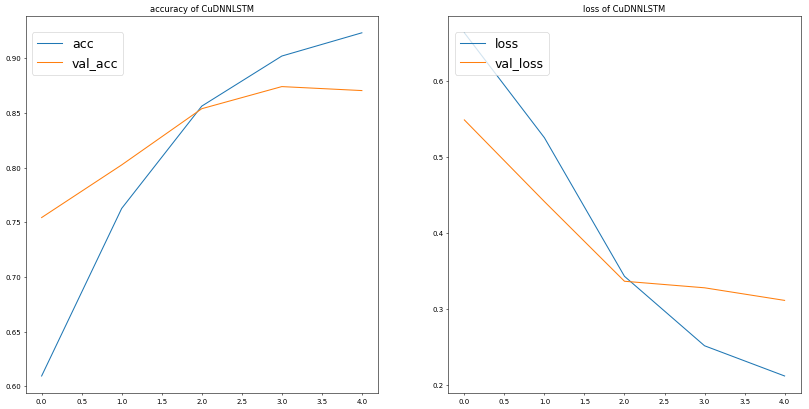

In [19]:
# 学習記録読み込み
model_logs = {'SimpleRNNCell' : pd.read_csv('SimpleRNNCell_training.log'),
                    'GRUCell' : pd.read_csv('GRUCell_training.log'),
                    'LSTMCell' : pd.read_csv('LSTMCell_training.log'),
                    'SimpleRNN': pd.read_csv('SimpleRNN_training.log'),
                    'GRU': pd.read_csv('GRU_training.log'),
                    'LSTM': pd.read_csv('LSTM_training.log'),
                    'CuDNNGRU' : pd.read_csv('CuDNNGRU_training.log'),
                    'CuDNNLSTM' : pd.read_csv('CuDNNLSTM_training.log')}

# 面倒なのでepoch数ベタがき
x = range(5)

for m_log_key in model_logs:
    plt.figure(figsize=(20, 10), dpi=50)
    plt.subplot(1,2,1)
    plt.plot(x, model_logs[m_log_key]['acc'], label="acc")
    plt.plot(x, model_logs[m_log_key]['val_acc'], label="val_acc")
    plt.title("accuracy of {}".format(m_log_key))
    plt.legend(loc='center left', bbox_to_anchor=(0, 0.9), fontsize=18)

    plt.subplot(1,2,2)
    plt.plot(x, model_logs[m_log_key]['loss'], label="loss")
    plt.plot(x, model_logs[m_log_key]['val_loss'], label="val_loss")
    plt.title("loss of {}".format(m_log_key))
    plt.legend(loc='center left', bbox_to_anchor=(0, 0.9), fontsize=18)

plt.show()

GRU・LSTMとCuDNNGRU・CuDNNLSTM間では同じような学習曲線を描いた。  
しかし各種レイヤー(simpleRNN・GRU・LSTM)とRNNレイヤーに各種Cellを適用させた場合ではかなり差分が出ており、曲線も異なる線を描いている。

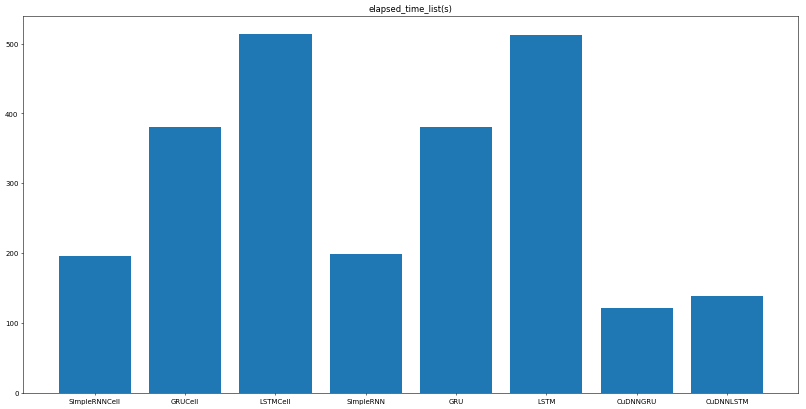

In [25]:
plt.figure(figsize=(20, 10), dpi=50)
plt.title("elapsed_time_list(s)")
plt.bar(range(len(elapsed_time_list)), list(elapsed_time_list.values()), align='center')
plt.xticks(range(len(elapsed_time_list)), list(elapsed_time_list.keys()))

plt.show()

CuDNNを使用したモデルは学習完了までの経過時間が短かった。  
- ConvLSTM2D  
畳み込みLSTM  
LSTMレイヤーに似ていますが，入力の変換とリカレントな変換が畳み込みです  
乳量は2次元配列を受け付ける

Train on 950 samples, validate on 50 samples
Epoch 1/5
950/950 [==============================] - 118s 125ms/step - loss: 0.2749 - val_loss: 0.1477
Epoch 2/5
950/950 [==============================] - 113s 119ms/step - loss: 0.0228 - val_loss: 0.0103
Epoch 3/5
950/950 [==============================] - 113s 119ms/step - loss: 0.0144 - val_loss: 0.0054
Epoch 4/5
950/950 [==============================] - 113s 119ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 5/5
950/950 [==============================] - 113s 119ms/step - loss: 0.0011 - val_loss: 9.3062e-04


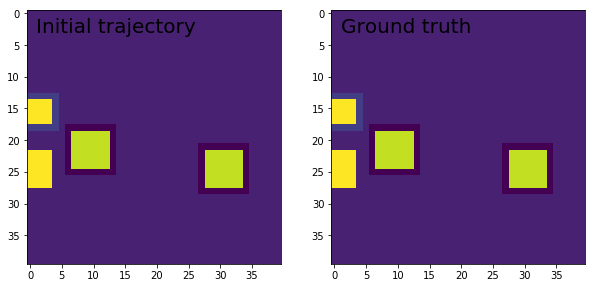

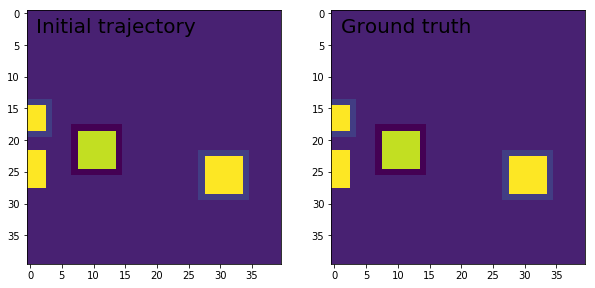

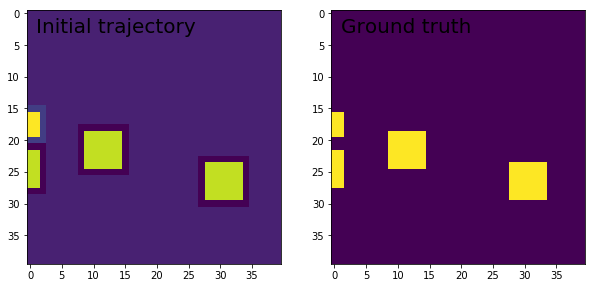

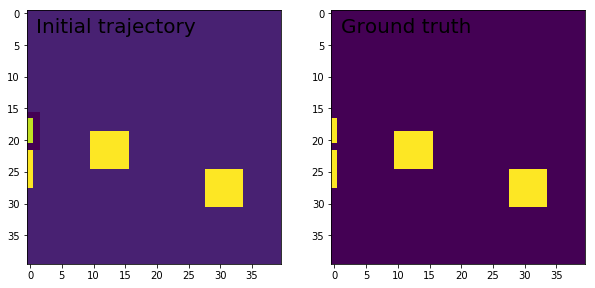

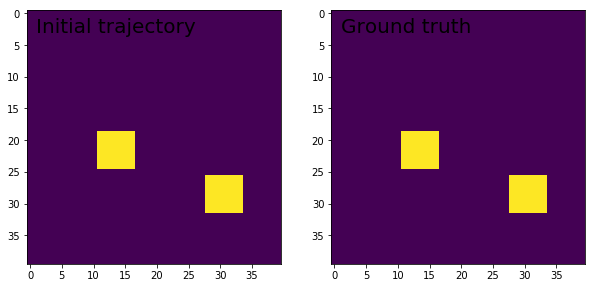

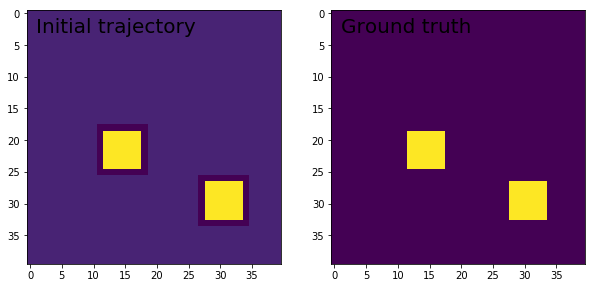

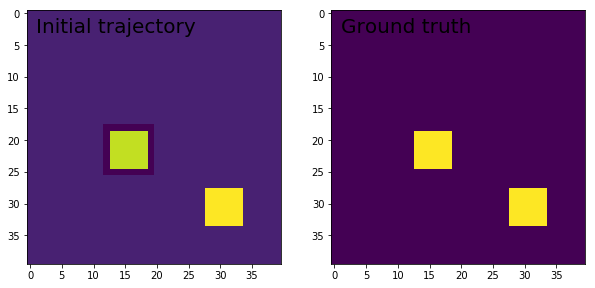

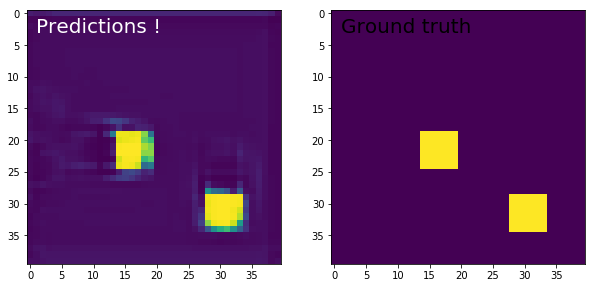

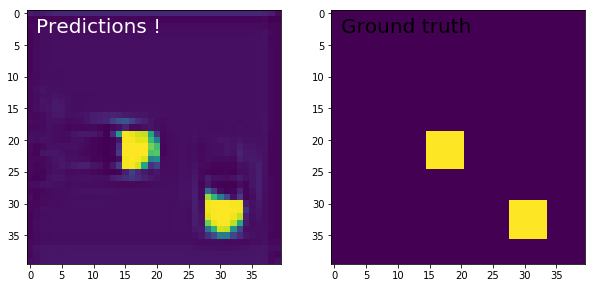

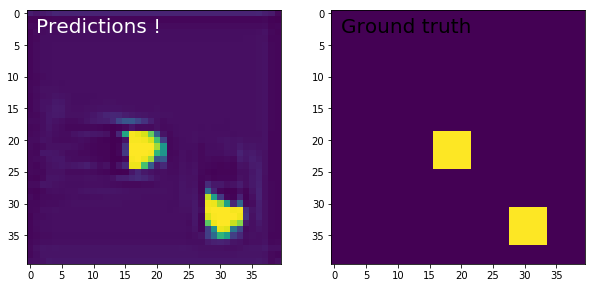

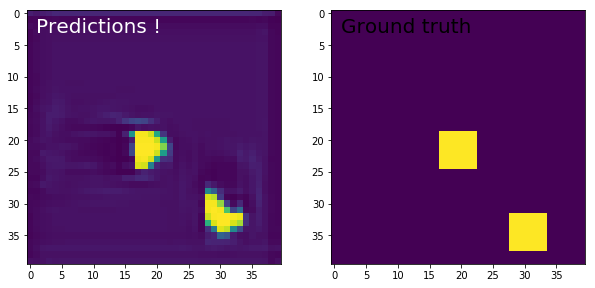

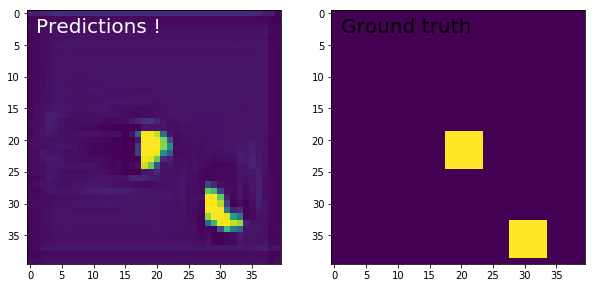

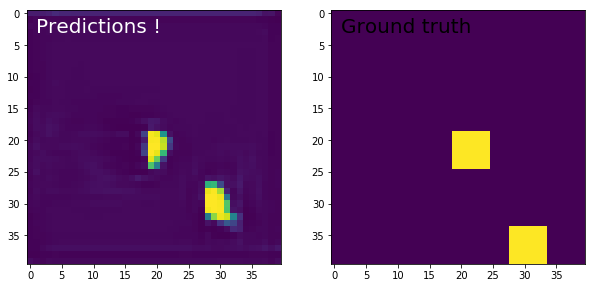

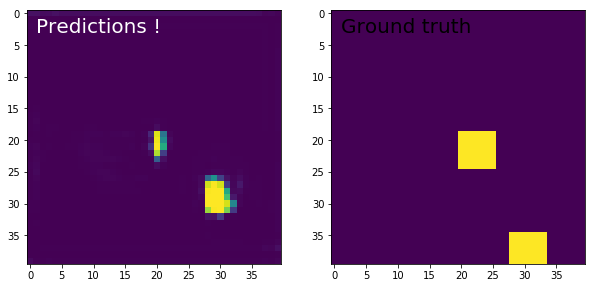

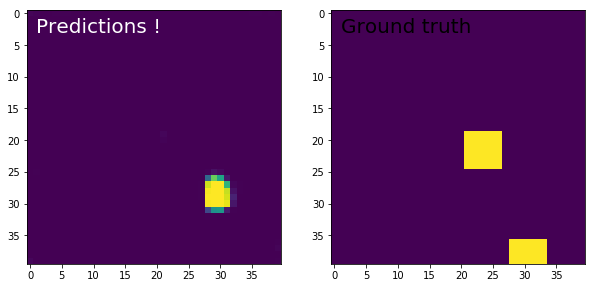

In [23]:
"""
#This script demonstrates the use of a convolutional LSTM network.
This network is used to predict the next frame of an artificially
generated movie which contains moving squares.
"""
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=5, validation_split=0.05)

# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))